# CascadingClassifier

Cascading es una técnica de ensambles que consiste en entrenar modelos con las instancias predichas con poca certeza por modelos anteriores. Como **sklearn** no provee este modelo, implementamos una versión propia simplificada.

In [1]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from scoring import *
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from scikeras.wrappers import KerasClassifier

from keras.models import Sequential
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from keras.regularizers import l2

import pandas as pd
import numpy as np
from joblib import dump, load
pd.set_option('display.max_rows', 10)

2021-12-07 12:53:27.373791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-07 12:53:27.373808: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Implementación

In [2]:
"""
Devuelve un array en el que el elemento x[i] es el elemento
mas alejado de 0.5 entre arr_a[i] y arr_b[i]
"""
def get_further(arr_a, arr_b):
    return np.array([a if abs(a - 0.5) > abs(b - 0.5) else b for a,b in zip(arr_a, arr_b)])

class CascadingClassifier:
    """
    threshold es la certeza minima que debe tener un modelo
    para clasificar correctamente una instancia. Todas las
    instancias cuya certeza sean menores que el threshold,
    se pasaran al siguiente modelo, tanto para el fit() como
    para el predict_proba()
    models es una lista de pares ('nombre', modelo)
    idx_to_use_calib es una lista con los indices de los modelos
    que deben ser calibrados (usando CalibratedClassifierCV)
    """
    def __init__(self, models, threshold, idx_to_use_calib):
        # Guardamos los modelos junto con sus calibradores
        # para que los resultados de predict_proba() sean mas
        # precisos
        # Si el usuario lo desea, puede desactivar esta opcion
        models_list = []
        for i, model_pair in enumerate(models):
            if i in idx_to_use_calib:
                models_list.append((model_pair[0], CalibratedClassifierCV(model_pair[1], n_jobs=-1)))
            else:
                models_list.append(model_pair)
        
        self.models = models_list
        self.threshold = threshold
    
    def fit(self, X_train, Y_train, verbose=True):
        return self._fit_rec(X_train, Y_train, self.models, verbose)
    
    """
    Entrena al primer modelo de models_subset
    si al predecir las mismas instancias con que
    fue entrenado la certeza es menor que el threshold
    (podemos confiar de este numero gracias a la calibracion)
    entonces se invoca recursivamente con el siguiente modelo
    pasando como parametros las instancias predichas con poca
    certeza
    """
    def _fit_rec(self, X_train_subset, Y_train_subset, models_subset, verbose):
        if len(models_subset) == 0:
            return
        model = models_subset[0][1]
        model_name = models_subset[0][0]
        
        model.fit(X_train_subset, Y_train_subset)
        model_output = model.predict_proba(X_train_subset)
        max_model_output = np.maximum(model_output[:,0], model_output[:,1])
        
        not_so_sure_points_index = np.where(max_model_output < self.threshold)[0]

        X_train_next_subset = X_train_subset[not_so_sure_points_index]
        Y_train_next_subset = Y_train_subset[not_so_sure_points_index]
        
        not_sure_len = len(not_so_sure_points_index)
        sure_len = len(model_output) - not_sure_len
        
        if verbose:
            print(f"Modelo: {model_name} logro clasificar {sure_len} instancias, {not_sure_len} no lograron ser clasificadas")
            
        self._fit_rec(X_train_next_subset, Y_train_next_subset, models_subset[1:], verbose)
        
    def predict_proba(self, X_test, verbose=True):
        # old_predict es una lista con todos los valores en 0.5
        # porque el modelo en la iteracion 0 no tiene ninguna certeza
        # sobre las predicciones, ya que no hay predicciones
        return self._predict_proba_rec(X_test, self.models, 0.5*np.ones(shape=len(X_test)), verbose)
    
    """
    Predice las instancias de test con el primer modelo de
    models_subset
    old_predict es una lista con las certezas de que cada instancia
    sea positiva (== 1)
    Se invoca recursivamente con aquellas instancias que no logro clasificar
    con certeza suficiente
    Devuelve una lista con los maximos entre old_predict y las nuevas predicciones
    (esto es para asegurar el maximo rendimiento para aquellas instancias que
    no fueron bien clasificadas incluso al agotarse los modelos de la lista)
    """
    def _predict_proba_rec(self, X_test_subset, models_subset, old_predict, verbose):
        if len(models_subset) == 0:
            return old_predict     
        model = models_subset[0][1]
        model_name = models_subset[0][0]

        model_output = model.predict_proba(X_test_subset)
        
        max_model_output = np.maximum(model_output[:,0], model_output[:,1])

        not_so_sure_points_index = np.where(max_model_output < self.threshold)[0]
        
        X_test_next_subset = X_test_subset[not_so_sure_points_index]
        model_output_not_so_sure = model_output[not_so_sure_points_index]
            
        not_sure_len = len(not_so_sure_points_index)
        sure_len = len(model_output) - not_sure_len
        
        if verbose:
            print(f"Modelo: {model_name} logro clasificar {sure_len} instancias, {not_sure_len} no lograron ser clasificadas")
        
        new_predictions = self._predict_proba_rec(X_test_next_subset, models_subset[1:], model_output_not_so_sure[:,1], verbose)
        
        for i, index in enumerate(not_so_sure_points_index):
            model_output[index][1] = new_predictions[i]
            
        return get_further(model_output[:,1], old_predict)

## Preprocessing Nº 1

In [3]:
np.random.seed(0)
df_features, df_target = get_datasets(fecha_to_int=False)

viento_trigonometrico(df_features)
df_features = barrios_a_comunas(df_features)
df_features = dia_a_mes(df_features)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=0)

pipe = iterative_imputer(max_iter=100)

pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### DecisionTreeClassifier y GaussianNB

In [4]:
models = [
    ("DecisionTree", DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=0)),
    ("GaussianNB", GaussianNB(var_smoothing=1e-8))
]

cascading = CascadingClassifier(models=models, threshold=0.9, idx_to_use_calib=[0, 1])

In [5]:
cascading.fit(X_train, Y_train)

Modelo: DecisionTree logro clasificar 27974 instancias, 38545 no lograron ser clasificadas
Modelo: GaussianNB logro clasificar 0 instancias, 38545 no lograron ser clasificadas


In [6]:
probas = cascading.predict_proba(X_test)
metrics_table(Y_test, probas > 0.5, probas)

Modelo: DecisionTree logro clasificar 14862 instancias, 20957 no lograron ser clasificadas
Modelo: GaussianNB logro clasificar 0 instancias, 20957 no lograron ser clasificadas


,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.867876,0.846953,0.762358,0.459658,0.573518


Vemos que Cascading no fue de utilidad, ya que Naive Bayes no pudo clasificar correctamente ninguna instancia. Probablemente sea necesario utilizar un modelo más complejo.

### DecisionTreeClassifier y RandomForestClassifier

In [7]:
models = [
    ("DecisionTree", DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=0)),
    ("RandomForest", RandomForestClassifier(criterion="entropy", max_depth=35, n_estimators=200, random_state=0))
]

cascading = CascadingClassifier(models=models, threshold=0.93, idx_to_use_calib=[0, 1])

In [8]:
cascading.fit(X_train, Y_train)

Modelo: DecisionTree logro clasificar 5977 instancias, 60542 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 31997 instancias, 28545 no lograron ser clasificadas


In [9]:
probas = cascading.predict_proba(X_test)
metrics_table(Y_test, probas > 0.5, probas)

Modelo: DecisionTree logro clasificar 3300 instancias, 32519 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 11169 instancias, 21350 no lograron ser clasificadas


,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.882108,0.85731,0.774236,0.511909,0.61632


El score es peor que al utilizar un único random forest. Es posible que el primer modelo, árbol de decisión, esté clasificando correctamente ciertas instancias, con una certeza mayor al threshold, pero menor a la que tendría si lo clasificara un random forest. Esto haría que el área bajo la curva ROC sea menor.

### Comparación gráfica de curvas ROC

Comparamos las curvas ROC del clasificador Cascading entrenado anteriormente, con el de un único random forest, para entender un poco mejor por qué el score dio peor.

In [10]:
rf = RandomForestClassifier(criterion="entropy", max_depth=35, n_estimators=200, n_jobs=-1, random_state=0)
rf_calib = CalibratedClassifierCV(rf)
rf_calib.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(criterion='entropy',
                                                             max_depth=35,
                                                             n_estimators=200,
                                                             n_jobs=-1,
                                                             random_state=0))

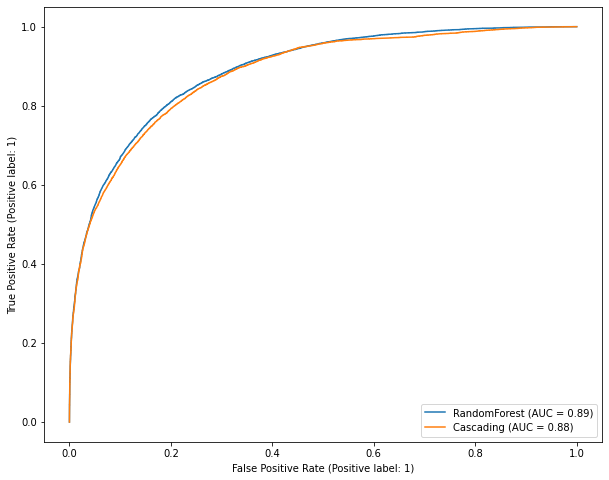

In [11]:
fig, ax = plt.subplots(figsize=(10,8))

RocCurveDisplay.from_predictions(Y_test, rf_calib.predict_proba(X_test)[:,1], ax=ax, name="RandomForest")
RocCurveDisplay.from_predictions(Y_test, probas, ax=ax, name="Cascading")

Efectivamente, ambas curvas son muy similares, pero la de Cascading tiene menos área, por lo tanto el score es menor. Esto probablemente indica una leve variación en las predicciones de algunas instancias, de modo que para ciertos umbrales la predicción es peor.

## Preprocessing Nº 2

In [12]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
pipe.fit(X_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### RandomForestClassifier y Red neuronal

Como pudimos comprobar, la utilización de modelos sencillos para la primera capa de cascading, si bien en teoría es una buena idea, en este caso los scores empeoraron. Por lo tanto, probamos la combinación de los dos mejores modelos que obtuvimos a lo largo del TP.

In [13]:
# Copio la funcion de NeuralNetwork.ipynb porque
# se precisa para cargar el modelo
def get_model(cant1, cant2, act1, act2, reg):
    model = Sequential()
    model.add(Dense(cant1, input_shape = (len(X_train[0]),), activation=act1, kernel_regularizer=l2(reg)))
    model.add(Dropout(0.2))
    model.add(Dense(cant2, input_shape = (len(X_train[0]),), activation=act2, kernel_regularizer=l2(reg)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adadelta(learning_rate = 1.0)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
    return model

grid = load('NeuralNetwork/grid.joblib') 

2021-12-07 12:57:10.690190: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-07 12:57:10.690210: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (elian): /proc/driver/nvidia/version does not exist
2021-12-07 12:57:10.690639: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
neural_network = grid.best_estimator_
# Probamos usar RandomForest como primer modelo pero
# los resultados empeoraban
models = [
    ("NeuralNetwork", neural_network),
    ("RandomForest", RandomForestClassifier(criterion="entropy", max_depth=35, n_estimators=200, random_state=0))
]

In [15]:
cascading_ = CascadingClassifier(models=models, threshold=0.85, idx_to_use_calib=[1])

In [16]:
cascading_.fit(X_train, Y_train)

Modelo: NeuralNetwork logro clasificar 42422 instancias, 24097 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 8734 instancias, 15363 no lograron ser clasificadas


In [17]:
probas = cascading_.predict_proba(X_test)

Modelo: NeuralNetwork logro clasificar 22538 instancias, 13281 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 272 instancias, 13009 no lograron ser clasificadas


In [18]:
metrics_table(Y_test, probas > 0.5, probas)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.895132,0.861442,0.774032,0.538222,0.634939


### Aumentando el threshold

Si aumentamos el threshold, el segundo modelo recibirá más instancias, tanto en fit() como en predict_proba(). Esto puede ser bueno, porque reduciría las probabilidades de que el segundo modelo overfitee. Por otro lado, si lo aumentamos mucho, el primer modelo no podrá predecir correctamente ninguna instancia, por lo que el segundo modelo recibiría todas las instancias, haciendo que el cascading pierda sentido.

In [19]:
cascading = CascadingClassifier(models=models, threshold=0.9, idx_to_use_calib=[1])

In [20]:
cascading.fit(X_train, Y_train)

Modelo: NeuralNetwork logro clasificar 35421 instancias, 31098 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 5185 instancias, 25913 no lograron ser clasificadas


In [21]:
probas = cascading.predict_proba(X_test)

Modelo: NeuralNetwork logro clasificar 18870 instancias, 16949 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 125 instancias, 16824 no lograron ser clasificadas


In [22]:
metrics_table(Y_test, probas > 0.5, probas)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.894747,0.860633,0.77148,0.536351,0.632779


Los modelos clasificaron correctamente menos instancias, como era esperado. Los scores se mantuvieron relativamente similares. Esto podría significar que a ambos modelos les resulta difícil clasificar el mismo set de instancias.

Podemos agregar mas modelos y ver si logran clasificar correctamente más instancias.

### Agregando SVC

Usamos la combinación de hiperparámetros que produjo los mejores resultados en SVC

In [23]:
if len(models) == 2:
    models.append(
        ("SVC", SVC(kernel = 'poly', random_state = 0, max_iter=100000, C = 1, degree = 3, coef0 = 1, gamma = 0.01, probability=True))
    )

In [24]:
cascading = CascadingClassifier(models=models, threshold=0.85, idx_to_use_calib=[1])

In [25]:
cascading.fit(X_train, Y_train)

Modelo: NeuralNetwork logro clasificar 42777 instancias, 23742 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 8054 instancias, 15688 no lograron ser clasificadas
Modelo: SVC logro clasificar 6 instancias, 15682 no lograron ser clasificadas


In [26]:
probas = cascading.predict_proba(X_test)

Modelo: NeuralNetwork logro clasificar 22819 instancias, 13000 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 202 instancias, 12798 no lograron ser clasificadas
Modelo: SVC logro clasificar 8 instancias, 12790 no lograron ser clasificadas


In [27]:
metrics_table(Y_test, probas > 0.5, probas)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.894299,0.86281,0.782119,0.536725,0.636592


Lamentablemente, SVC no pudo clasificar una cantidad significativa de instancias, por lo que el score se mantuvo prácticamente igual.

### Agregando KNN

In [28]:
if len(models) == 3:
    models.pop()
models.append(
    ("KNN", KNeighborsClassifier(n_neighbors = 55, weights = "distance"))
)

In [29]:
cascading = CascadingClassifier(models=models, threshold=0.85, idx_to_use_calib=[1, 2])

In [30]:
cascading.fit(X_train, Y_train)

Modelo: NeuralNetwork logro clasificar 41559 instancias, 24960 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 9789 instancias, 15171 no lograron ser clasificadas
Modelo: KNN logro clasificar 0 instancias, 15171 no lograron ser clasificadas


In [31]:
probas = cascading.predict_proba(X_test)

Modelo: NeuralNetwork logro clasificar 22147 instancias, 13672 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 336 instancias, 13336 no lograron ser clasificadas
Modelo: KNN logro clasificar 0 instancias, 13336 no lograron ser clasificadas


In [32]:
metrics_table(Y_test, probas > 0.5, probas)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.894677,0.862782,0.777143,0.542711,0.639107


El nuevo modelo no alcanzó el threshold en ninguna instancia. Sin embargo, el score aumento ligeramente. Esto quiere decir que mejoró la predicción de alguna instancia, a pesar de que la certeza no fue mayor a 0.85

Como conclusión, podemos ver que es difícil mejorar los scores utilizando cascading, principalmente por dos motivos:
- Si se utilizan dos modelos de complejidad similar (ej: árbol de decisión y Naive Bayes), las instancias predichas con poca certeza por un modelo, serán predichas con poca certeza por el otro.
- Si se utiliza un modelo simple y luego un modelo complejo (ej: árbol de decisión y Random Forest), las instancias predichas con buena certeza por el primer modelo, podrían ser predichas con más certeza por el segundo. Pero como se supera el threshold, dichas instancias quedarán con las probabilidades del primer modelo. Bajo la métrica ROC AUC, esto implica un peor score.

Finalmente, nos quedamos con el modelo que utilizó una red neuronal y random forest (*threshold* = $0.85$) ya que, si bien el score fue un poco menor al último modelo, es más simple (el último modelo agrega KNN, es decir, un estimador base más).

## Predicción de nuevos datos

In [33]:
df_extra = pd.read_csv("datasets/df_extra.csv", low_memory = False, index_col = "id")

common(df_extra)
viento_trigonometrico(df_extra)
df_extra = hashing_trick(df_extra, 24, "barrio")

model = cascading_

pipe.steps.append(("casc", model))

df_extra_predict = pd.DataFrame({"id": df_extra.index, "llovieron_hamburguesas_al_dia_siguiente": pipe.predict_proba(df_extra) > 0.5})
df_extra_predict.set_index("id", inplace = True)
df_extra_predict.replace({"llovieron_hamburguesas_al_dia_siguiente": {False: "no", True: "si"}}, inplace = True)
df_extra_predict.to_csv("predicciones/CascadingClassifier.csv")

Modelo: NeuralNetwork logro clasificar 18141 instancias, 10951 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 205 instancias, 10746 no lograron ser clasificadas
